### **Face Mask Segmentation**

This notebook explores both traditional and deep learning-based methods for face mask segmentation.  

#### **Traditional Methods:**
1. **Region Growing Segmentation:** Expands regions based on pixel similarity to segment the mask area.  
2. **Edge Contour Segmentation:** Detects mask boundaries using edge-based techniques.  
3. **Thresholding Segmentation:** Segments the mask region based on intensity thresholds.  

#### **Deep Learning Method:**
- **UNet:** A fully convolutional neural network designed for pixel-wise segmentation, trained to accurately segment face masks.  

The implementation includes dataset preprocessing, model training, and evaluation of segmentation performance.


In [4]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [5]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
# Define dataset class
class FaceMaskDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, img_size=(128, 128)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size) / 255.0  # Normalize image

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_size)
        mask = np.expand_dims(mask, axis=0) / 255.0  # Normalize mask
        mask_tensor = torch.tensor(mask, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, mask_tensor


In [13]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# Load and split dataset
image_dir = "/content/drive/MyDrive/MSFD/1/face_crop"
mask_dir = "/content/drive/MyDrive/MSFD/1/face_crop_segmentation"
# Get only filenames that exist in both folders
image_filenames = sorted(os.listdir(image_dir))
mask_filenames = set(os.listdir(mask_dir))  # Convert to a set for fast lookup

# Filter images to keep only those that have a corresponding mask
image_filenames = [f for f in image_filenames if f in mask_filenames]
mask_filenames = sorted(image_filenames)  # Ensure masks are in the same order

image_paths = [os.path.join(image_dir, f) for f in image_filenames]
mask_paths = [os.path.join(mask_dir, f) for f in mask_filenames]

train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

train_dataset = FaceMaskDataset(train_images, train_masks, transform=transform)
val_dataset = FaceMaskDataset(val_images, val_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)


## **Via Traditional Methods**

In [36]:
# # Function to apply threshold segmentation
def threshold_segmentation(image):
    """Segment mask using Otsu's thresholding."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

def region_growing_segmentation(image, seed=None, threshold=30):
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if seed is None:
        seed = (image.shape[0] // 2, image.shape[1] // 2)

    height, width = image.shape
    mask = np.zeros_like(image, dtype=np.uint8)
    visited = np.zeros_like(image, dtype=bool)

    seed_value = image[seed]
    stack = [seed]

    while stack:
        x, y = stack.pop()
        if visited[x, y]:
            continue
        visited[x, y] = True

        if abs(int(image[x, y]) - int(seed_value)) < threshold:
            mask[x, y] = 255

            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < height and 0 <= ny < width and not visited[nx, ny]:
                    stack.append((nx, ny))

    return mask

def edge_contour_segmentation(image):
    """Segment mask using Canny edge detection + contour filling."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)  # Edge detection
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    return mask

In [37]:
def evaluate_segmentation(pred_mask, true_mask):
    try:
        pred_mask = (pred_mask > 127).astype(np.uint8).flatten()
        true_mask = (true_mask > 127).astype(np.uint8).flatten()

        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()
        iou = intersection / union if union != 0 else 1.0
        dice = (2 * intersection) / (pred_mask.sum() + true_mask.sum()) if (pred_mask.sum() + true_mask.sum()) != 0 else 1.0
        accuracy = (pred_mask == true_mask).mean()

        return iou, dice, accuracy
    except Exception as e:
        print(f"Error in evaluation: {e}")
        return 0.0, 0.0, 0.0


In [38]:
def process_and_evaluate(data_loader):
    iou_scores = {"Threshold": [], "Region Growing": [], "Edge Contour": []}
    dice_scores = {"Threshold": [], "Region Growing": [], "Edge Contour": []}
    accuracy_scores = {"Threshold": [], "Region Growing": [], "Edge Contour": []}

    fig, axes = plt.subplots(5, 5, figsize=(18, 15))
    sample_count = 0

    for i, (images, true_masks) in enumerate(data_loader):
        # images = images.permute(0, 2, 3, 1).numpy() * 255  # Convert BCHW to
        images = (images.permute(0, 2, 3, 1).cpu().numpy() * 255).astype(np.uint8)
        true_masks = true_masks.squeeze(1).numpy() * 255  # Convert BCHW to BHW


        for j in range(images.shape[0]):
            image = images[j].astype(np.uint8)
            true_mask = true_masks[j].astype(np.uint8)

            threshold_mask = threshold_segmentation(image)
            region_mask = region_growing_segmentation(image)
            edge_mask = edge_contour_segmentation(image)

            iou_t, dice_t, acc_t = evaluate_segmentation(threshold_mask, true_mask)
            iou_r, dice_r, acc_r = evaluate_segmentation(region_mask, true_mask)
            iou_e, dice_e, acc_e = evaluate_segmentation(edge_mask, true_mask)

            iou_scores["Threshold"].append(iou_t)
            iou_scores["Region Growing"].append(iou_r)
            iou_scores["Edge Contour"].append(iou_e)

            dice_scores["Threshold"].append(dice_t)
            dice_scores["Region Growing"].append(dice_r)
            dice_scores["Edge Contour"].append(dice_e)

            accuracy_scores["Threshold"].append(acc_t)
            accuracy_scores["Region Growing"].append(acc_r)
            accuracy_scores["Edge Contour"].append(acc_e)

            if sample_count < 5:
                # axes[sample_count, 0].imshow(image.astype(np.uint8))
                # axes[sample_count, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axes[sample_count, 0].imshow(image)
                axes[sample_count, 0].set_title("Original")

                axes[sample_count, 1].imshow(true_mask, cmap="gray")
                axes[sample_count, 1].set_title("Ground Truth")

                axes[sample_count, 2].imshow(threshold_mask, cmap="gray")
                axes[sample_count, 2].set_title("Threshold")

                axes[sample_count, 3].imshow(region_mask, cmap="gray")
                axes[sample_count, 3].set_title("Region Growing")

                axes[sample_count, 4].imshow(edge_mask, cmap="gray")
                axes[sample_count, 4].set_title("Edge Contour")

                sample_count += 1

    plt.tight_layout()
    plt.show()

    for method in ["Threshold", "Region Growing", "Edge Contour"]:
        print(f"{method} Mean IoU: {np.mean(iou_scores[method]):.4f}")
        print(f"{method} Mean Dice: {np.mean(dice_scores[method]):.4f}")
        print(f"{method} Mean Accuracy: {np.mean(accuracy_scores[method]):.4f}\n")


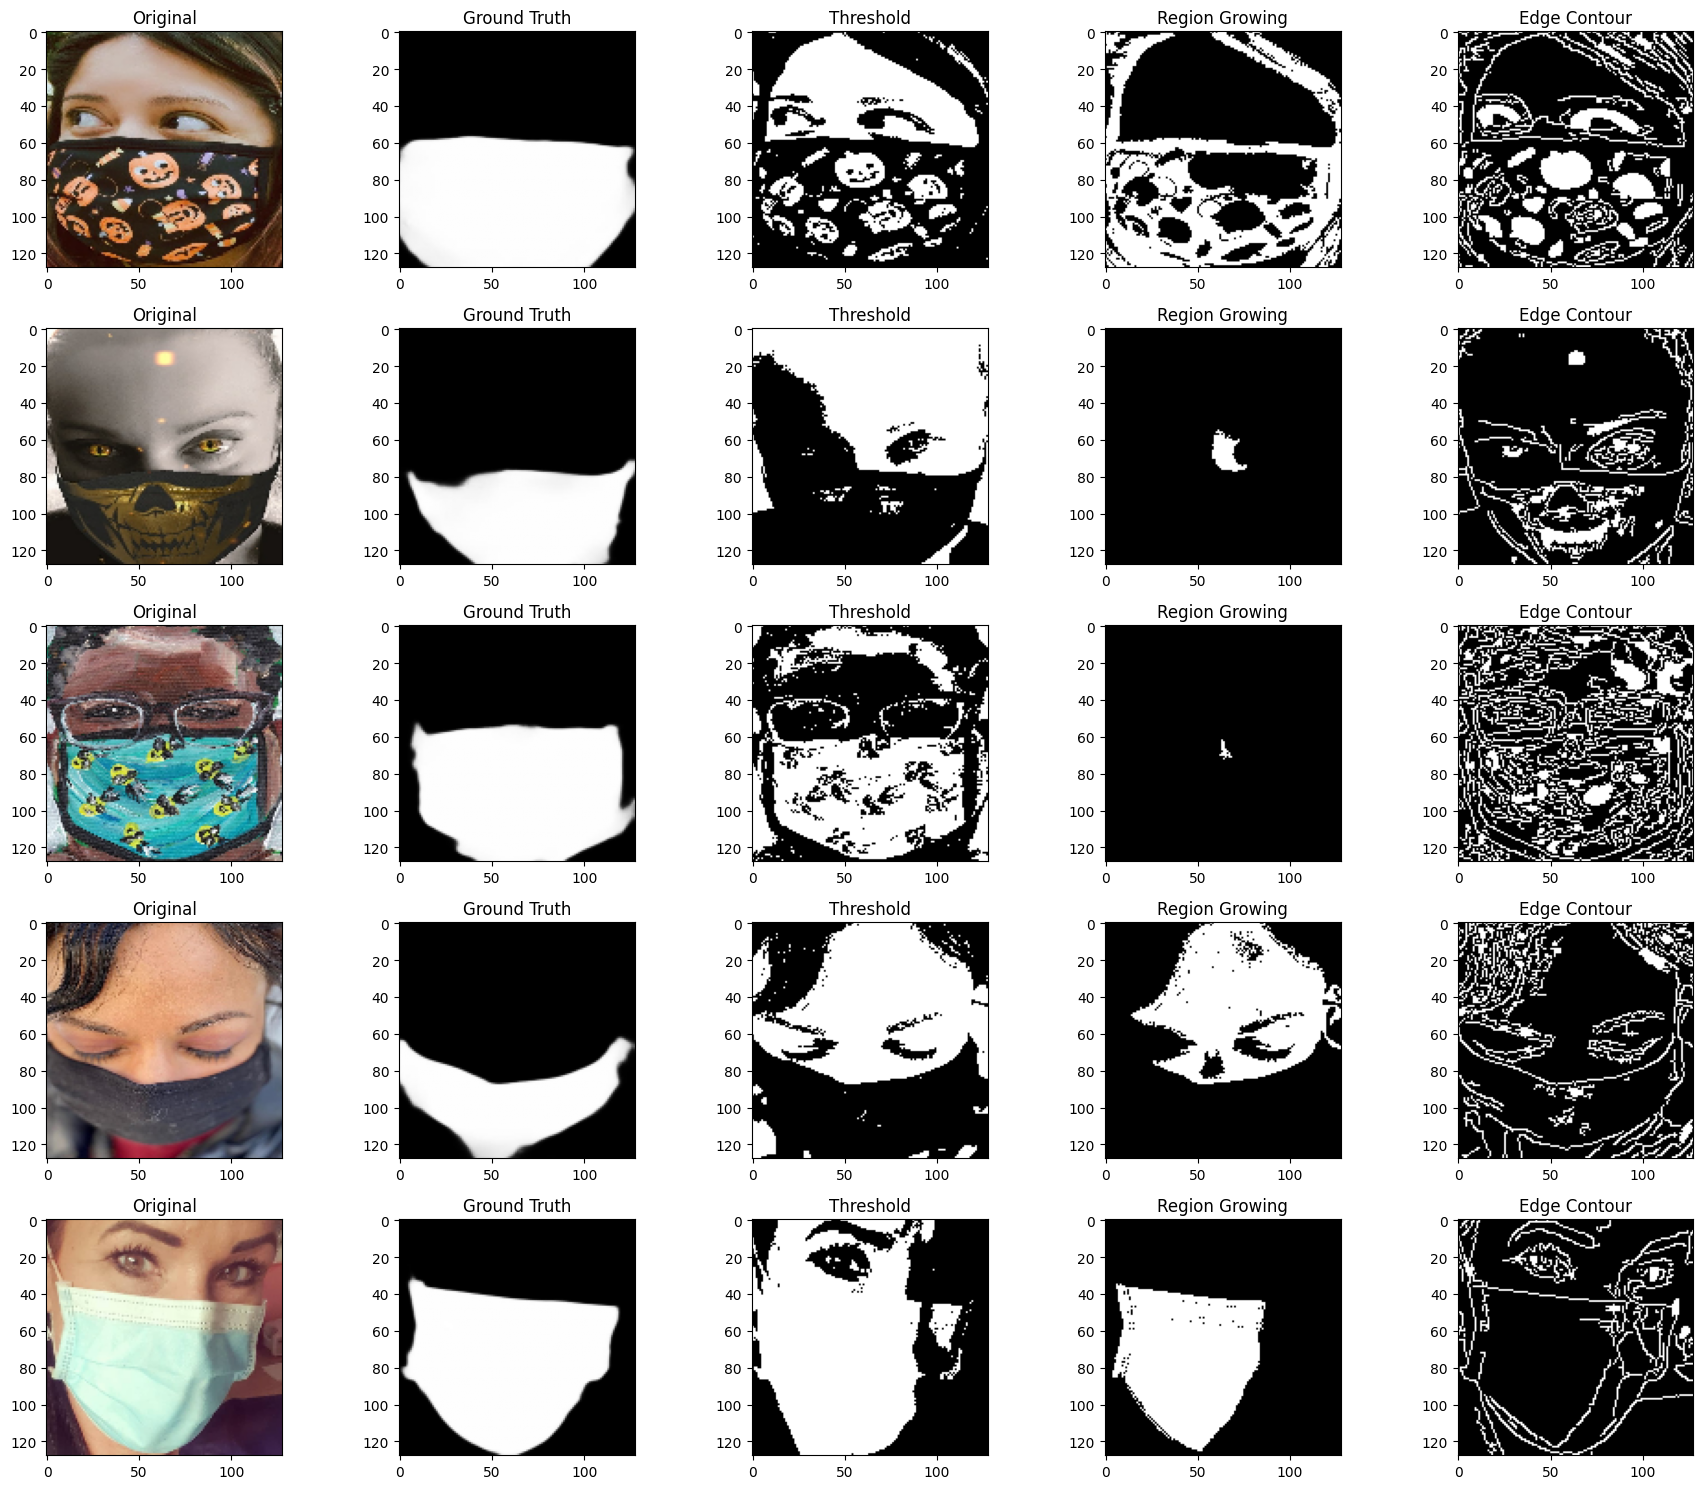

Threshold Mean IoU: 0.2909
Threshold Mean Dice: 0.4052
Threshold Mean Accuracy: 0.5291

Region Growing Mean IoU: 0.2755
Region Growing Mean Dice: 0.3652
Region Growing Mean Accuracy: 0.6730

Edge Contour Mean IoU: 0.1563
Edge Contour Mean Dice: 0.2552
Edge Contour Mean Accuracy: 0.6305



In [39]:
process_and_evaluate(val_loader)


## **Via Unet method**

In [4]:
# Dice Loss Function
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# BCE + Dice Loss
def bce_dice_loss(pred, target, alpha=0.5):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return alpha * bce + (1 - alpha) * dice

In [8]:
# Define U-Net model with reduced blocks
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(3, 32)
        self.enc2 = conv_block(32, 64)
        self.enc3 = conv_block(64, 128)
        self.bottleneck = conv_block(128, 256)

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = conv_block(256, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(128, 64)

        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec3 = conv_block(64, 32)

        self.final = nn.Conv2d(32, 1, kernel_size=1)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))

        d1 = self.dec1(torch.cat([self.up1(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d1), e2], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d2), e1], dim=1))

        return self.final(d3)

In [9]:
# Initialize model
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# criterion = nn.BCEWithLogitsLoss()
criterion = bce_dice_loss

def train(model, dataloader, epochs=10):
    model.train()
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, masks in progress_bar:
            images, masks = images.to(device).float(), masks.to(device).float()
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=epoch_loss / len(dataloader))
        torch.save(model.state_dict(), f"unet_face_mask_epoch_{epoch+1}.pth")


# Train the model
train(model, train_loader, epochs=10)



<ipython-input-9-2a3c02ac22fd>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/10:   0%|          | 0/470 [00:00<?, ?it/s]<ipython-input-9-2a3c02ac22fd>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/10: 100%|██████████| 470/470 [00:52<00:00,  8.89it/s, loss=0.0784]


In [32]:
# Function to visualize results
def visualize_results(model, dataloader, num_samples=5):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(dataloader))
        images, masks = images.to(device).float(), masks.to(device).float()
        outputs = torch.sigmoid(model(images))

        fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
        for i in range(num_samples):
            axes[i, 0].imshow(images[i].cpu().permute(1, 2, 0).numpy())
            axes[i, 0].set_title("Original Image")
            axes[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')
            axes[i, 1].set_title("Ground Truth")
            axes[i, 2].imshow(outputs[i].cpu().squeeze(), cmap='gray')
            axes[i, 2].set_title("Predicted Mask")
        plt.show()

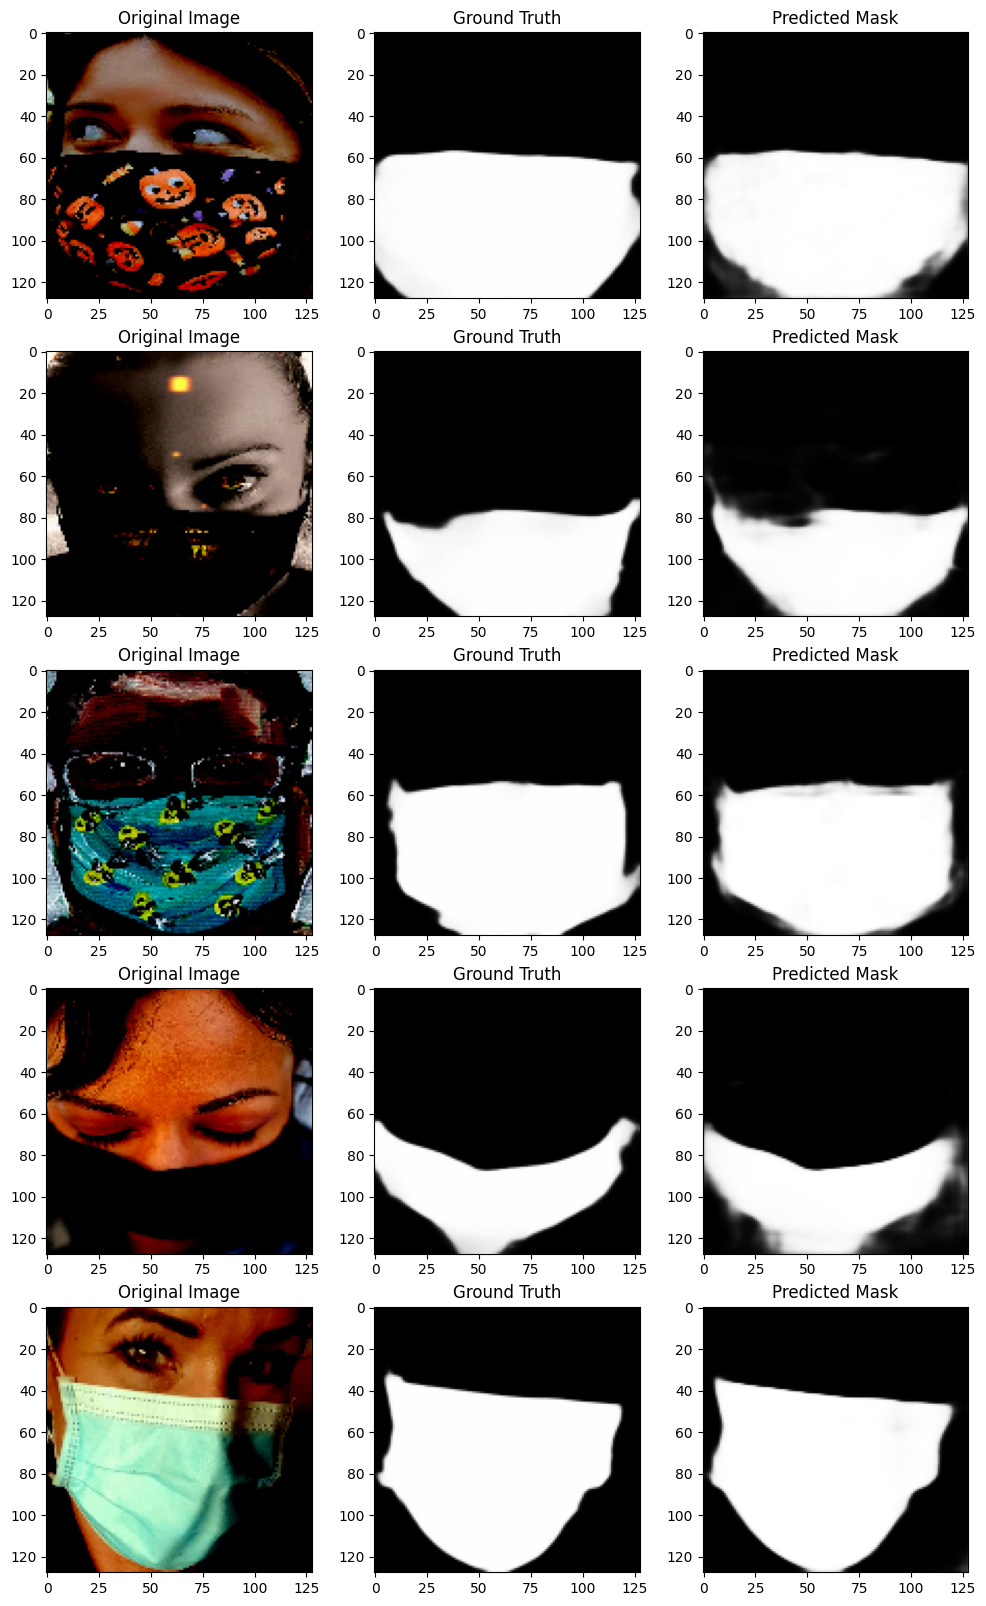

In [33]:
visualize_results(model, val_loader)

In [34]:
# Function to evaluate model performance
def evaluate_model(model, dataloader):
    model.eval()
    total_iou, total_dice, total_accuracy, count = 0, 0, 0, 0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device).float(), masks.to(device).float()
            outputs = torch.sigmoid(model(images))
            preds = (outputs > 0.5).float()

            intersection = (preds * masks).sum(dim=(1, 2, 3))
            union = preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) - intersection
            dice = (2. * intersection + 1e-6) / (preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) + 1e-6)
            iou = (intersection + 1e-6) / (union + 1e-6)
            accuracy = (preds == masks).float().mean()

            total_iou += iou.mean().item()
            total_dice += dice.mean().item()
            total_accuracy += accuracy.item()
            count += 1

    mean_iou = total_iou / count
    mean_dice = total_dice / count
    mean_accuracy = total_accuracy / count

    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice Score: {mean_dice:.4f}")
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

    return mean_iou, mean_dice, mean_accuracy

# Evaluate model
evaluate_model(model, val_loader)


Mean IoU: 0.8944
Mean Dice Score: 0.9390
Mean Accuracy: 0.6119


(0.8944431285736925, 0.9389871419486353, 0.6119051075587838)